In [ ]:
pip install -q snscrape transformers matplotlib wordcloud seaborn scikit-plot contractions nltk regex tweetnlp

In [1]:
# Importing Libraries
from flask import Flask, render_template, request, url_for
from PIL import Image
import pandas as pd
import numpy as np
import tweepy
import warnings
import snscrape.modules.twitter as sntwitter
import requests
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tweetnlp
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer

C:\Users\temit\anaconda3\envs\myenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\temit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\temit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
TExtract = pd.read_csv('TwitterExtract.csv',encoding= 'MacRoman')

In [6]:
TExtract.head()

,Datetime,Text,Username,Retweet,Views,Search Criteria,"Positive (P), Negative(N), Both(B), Neutral(U)"
0,10/02/2023,Say What You Want But This Harry Potter Is The...,NaN,1,967,Harry Potter,P
1,01/02/2023,Where?S The Edd Bank Of America BeyoncÈ Presale?,AmyScarlata,1,212,Bank Of America,P
2,26/01/2023,@Besoccerfr Pep Guardiola And Pulisitch,Khaled_Dz_2006,0,19,Pep Guardiola,P
3,10/02/2023,@Bluedinifree @Marshablackburn He Was Getting ...,JamesAR1116,0,17,Netflix,U
4,10/02/2023,@Wizard_Coder @Bearbulltraders I Trade Perpetu...,RecoveryTraders,0,37,Ftx,U


In [7]:
TExtract.rename(columns={"Positive (P), Negative(N), Both(B), Neutral(U)": "Sentiment"}, inplace=True)

sentiment_mapping = {'P': 'positive', 'N': 'negative', 'U': 'neutral', 'B': 'both'} # Define a mapping of old values to new values
TExtract['Sentiment'] = TExtract['Sentiment'].replace(sentiment_mapping)

In [8]:
valid_sentiments = ['positive', 'negative', 'neutral'] # Define a list of valid sentiments
TExtract = TExtract[TExtract['Sentiment'].isin(valid_sentiments)]

In [9]:
TExtract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27279 entries, 0 to 29998
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Datetime         27279 non-null  object
 1   Text             27279 non-null  object
 2   Username         24536 non-null  object
 3   Retweet          27279 non-null  int64 
 4   Views            27279 non-null  int64 
 5   Search Criteria  27279 non-null  object
 6   Sentiment        27279 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.7+ MB


In [10]:
print ('============================================')
print ("Search Criteria breakdown")
print ('============================================')
TExtract['Search Criteria'].value_counts().head(20)

Search Criteria breakdown


Search Criteria
Harry Potter    745
Adele           708
Netflix         697
Lebron James    690
Amouranth       670
Liz Truss       655
Primark         646
Coca-cola       622
Amazon          612
Andrew Tate     603
Wayfair         594
Walmart         582
Chelsea         575
Iphone          567
Tesco           563
Arsenal         560
Paypal          559
Chris Brown     539
Burna Boy       535
Asda            522
Name: count, dtype: int64

In [11]:
TExtract['TextClean'] = TExtract['Text']

In [31]:
topic = 'Iphone'

In [32]:
location = 'London'

In [51]:
Filteredtweets = TExtract[TExtract['Search Criteria'] == 'Iphone'].copy()

In [13]:
Filteredtweets.reset_index(inplace=True)

In [14]:
Filteredtweets.head()

,index,Datetime,Text,Username,Retweet,Views,Search Criteria,Sentiment,TextClean
0,5,07/02/2023,"? Tagged #Hashtag,#Ciberamenazas,#Ciberconsejo...",rafemi,0,27,Iphone,neutral,"? Tagged #Hashtag,#Ciberamenazas,#Ciberconsejo..."
1,19,28/12/2022,"Hey @Apple , With All Of These System Updates,...",MrAveryBrown,0,77,Iphone,positive,"Hey @Apple , With All Of These System Updates,..."
2,65,26/01/2023,Can I Ask All You Apple Product Users: Why Wou...,cunderw12,0,147,Iphone,positive,Can I Ask All You Apple Product Users: Why Wou...
3,237,31/01/2023,@Apple Please Fix The Voice Notes Not Being Ab...,NandyVersatil,0,30,Iphone,positive,@Apple Please Fix The Voice Notes Not Being Ab...
4,248,24/12/2022,Rip #Twitterforiphone And #Twitterforandroid #...,ninaadsadaphal,0,18,Iphone,positive,Rip #Twitterforiphone And #Twitterforandroid #...


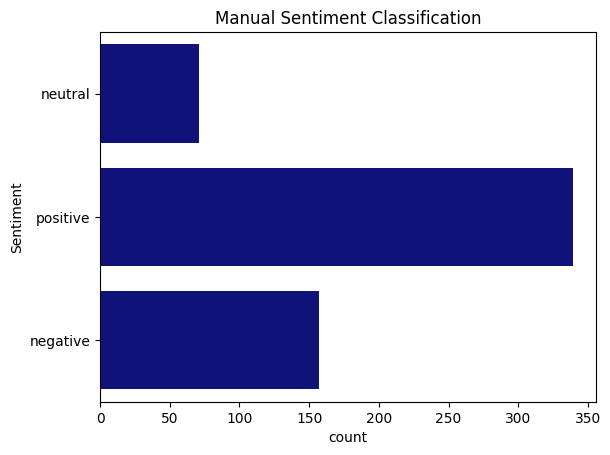

In [15]:
sns.countplot(y='Sentiment', data=Filteredtweets, color = 'darkblue')
plt.title('Manual Sentiment Classification')
plt.show()

In [16]:
# remove '\n', lowercase all letters
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: x.replace('\n',' ').lower())

# expand contractions
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: contractions.fix(x))

# remove punctuations
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: re.sub(r'[^\w\s]','',x))

#remove HTML tags
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: re.sub(re.compile('<.*?>'), '', x))

#remove consecutive characters that occur three or more times in a row, and replace them with just two occurrences of that character.
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: re.compile(r"(.)\1{2,}").sub(r"\1\1", x))

# Removing extra spaces
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: re.sub(' +',' ',x))

# Removing stop words
#stop_words = set(stopwords.words('english'))
#Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Tokenize the text data using NLTK
# Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: word_tokenize(x))

In [17]:
Filteredtweets[['Text', 'TextClean']]

,Text,TextClean
0,"? Tagged #Hashtag,#Ciberamenazas,#Ciberconsejo...",tagged hashtagciberamenazasciberconsejosciber...
1,"Hey @Apple , With All Of These System Updates,...",hey apple with all of these system updates i n...
2,Can I Ask All You Apple Product Users: Why Wou...,can i ask all you apple product users why woul...
3,@Apple Please Fix The Voice Notes Not Being Ab...,apple please fix the voice notes not being abl...
4,Rip #Twitterforiphone And #Twitterforandroid #...,rip twitterforiphone and twitterforandroid twi...
...,...,...
562,@Velcocinemas Last Time License This Time #Iph...,velcocinemas last time license this time iphon...
563,1/ It's So Unfortunate That Ftx One Of The Wor...,1 it is so unfortunate that ftx one of the wor...
564,"Today, I Changed My #Iphone Apps Settings. 1. ...",today i changed my iphone apps settings 1 appl...
565,#Iphone Chargers Should Be Called Apple Juice,iphone chargers should be called apple juice


In [18]:
Filteredtweets['TextClean']

0       tagged hashtagciberamenazasciberconsejosciber...
1      hey apple with all of these system updates i n...
2      can i ask all you apple product users why woul...
3      apple please fix the voice notes not being abl...
4      rip twitterforiphone and twitterforandroid twi...
                             ...                        
562    velcocinemas last time license this time iphon...
563    1 it is so unfortunate that ftx one of the wor...
564    today i changed my iphone apps settings 1 appl...
565         iphone chargers should be called apple juice
566    kodak 35mm film is so pricey i cant afford to ...
Name: TextClean, Length: 567, dtype: object

In [63]:
# Load the model
model = tweetnlp.load_model('sentiment')

# Define the sentiment analysis function
def get_sentiment(text):
    return model.sentiment(text)['label']

# Apply the function to each row of the 'filtertweet[textclean]' column and store the result in a new column called 'sentiment'
Filteredtweets['Tweetsentiment'] = Filteredtweets['TextClean'].apply(get_sentiment)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# Load the model
model = tweetnlp.load_model('sentiment')

# Define the sentiment analysis function
def get_sentiment(text):
    return model.sentiment(text)['label']

# Apply the function to each row of the 'filtertweet[textclean]' column and store the result in a new column called 'sentiment'
Filteredtweets['TweetsentimentNoCleaning'] = Filteredtweets['Text'].apply(get_sentiment)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
Filteredtweets['Tweetsentiment'].value_counts()

Tweetsentiment
neutral     239
negative    192
positive    136
Name: count, dtype: int64

In [22]:
Filteredtweets['TweetsentimentNoCleaning'].value_counts()

TweetsentimentNoCleaning
neutral     262
negative    176
positive    129
Name: count, dtype: int64

In [23]:
Filteredtweets['Sentiment'].value_counts()

Sentiment
positive    339
negative    157
neutral      71
Name: count, dtype: int64

In [47]:
#Change date format in python pandas yyyy-mm-dd to dd-mm-yyyy
Filteredtweets['Datetime'] = pd.to_datetime(Filteredtweets['Datetime'], format='mixed').dt.strftime('%d-%m-%Y')

In [49]:
Filteredtweets['Datetime']

0      07-02-2023
1      28-12-2022
2      26-01-2023
3      31-01-2023
4      24-12-2022
          ...    
562    15-01-2023
563    28-01-2023
564    28-12-2022
565    16-01-2023
566    13-01-2023
Name: Datetime, Length: 567, dtype: object

In [40]:
# Create a list of dates
dates = sorted(Filteredtweets['Datetime'].unique())

In [42]:
from datetime import datetime

# Create a list of dates
dates = Filteredtweets['Datetime'].unique()

# Convert dates to datetime objects
date_objs = [datetime.strptime(date, '%d-%m-%Y') for date in dates]

# Sort datetime objects
sorted_date_objs = sorted(date_objs)

# Convert sorted datetime objects back to strings
sorted_dates = [date_obj.strftime('%d-%m-%Y') for date_obj in sorted_date_objs]

In [43]:
sorted_dates

['18-12-2022',
 '19-12-2022',
 '20-12-2022',
 '21-12-2022',
 '22-12-2022',
 '23-12-2022',
 '24-12-2022',
 '25-12-2022',
 '26-12-2022',
 '27-12-2022',
 '28-12-2022',
 '29-12-2022',
 '30-12-2022',
 '31-12-2022',
 '01-01-2023',
 '02-01-2023',
 '13-01-2023',
 '14-01-2023',
 '15-01-2023',
 '16-01-2023',
 '17-01-2023',
 '18-01-2023',
 '19-01-2023',
 '20-01-2023',
 '21-01-2023',
 '22-01-2023',
 '23-01-2023',
 '24-01-2023',
 '25-01-2023',
 '26-01-2023',
 '27-01-2023',
 '28-01-2023',
 '29-01-2023',
 '30-01-2023',
 '31-01-2023',
 '01-02-2023',
 '02-02-2023',
 '01-03-2023',
 '02-03-2023',
 '01-04-2023',
 '02-04-2023',
 '01-05-2023',
 '02-05-2023',
 '01-06-2023',
 '02-06-2023',
 '01-07-2023',
 '02-07-2023',
 '01-08-2023',
 '02-08-2023',
 '01-09-2023',
 '02-09-2023',
 '01-10-2023',
 '02-10-2023',
 '01-11-2023',
 '01-12-2023']

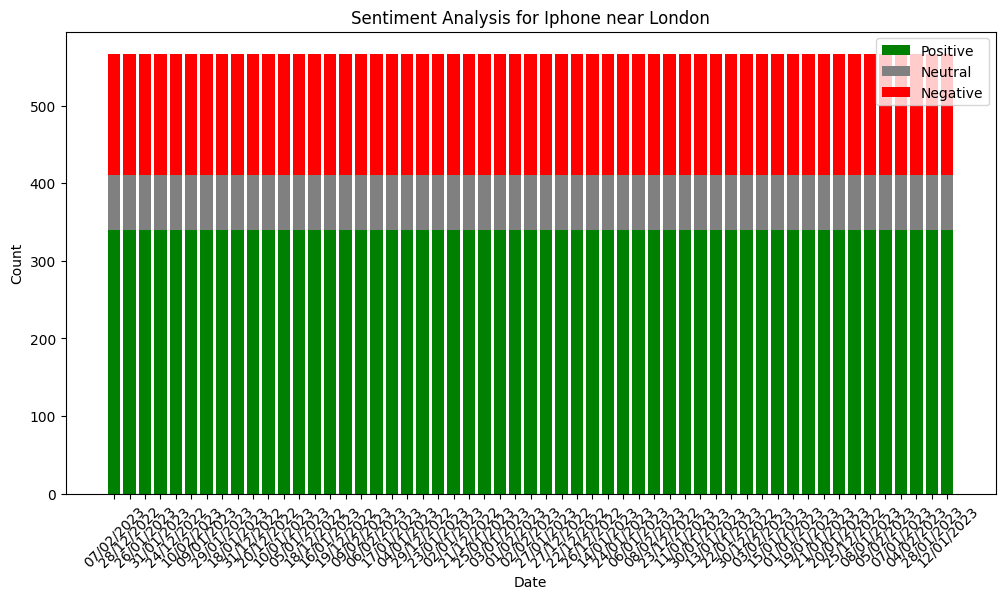

In [55]:

# Create a list of dates
dates = Filteredtweets['Datetime'].unique()

# Create a list of counts for each sentiment for each date
pos_counts = []
neg_counts = []
neu_counts = []

for date in dates:
    df = Filteredtweets
    pos_counts.append(len(df[df['Sentiment'] == 'positive']))
    neg_counts.append(len(df[df['Sentiment'] == 'negative']))
    neu_counts.append(len(df[df['Sentiment'] == 'neutral']))

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(dates, pos_counts, label='Positive', color='green')
ax.bar(dates, neu_counts, bottom=pos_counts, label='Neutral', color='gray')
ax.bar(dates, neg_counts, bottom=np.array(pos_counts)+np.array(neu_counts), label='Negative', color='red')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title(f'Sentiment Analysis for {topic} near {location}')
plt.xticks(rotation=45)

# Save the plot to a PNG file
plt.savefig('static/img/sentiment_stacked_bar_chart.png', dpi=300, bbox_inches='tight')


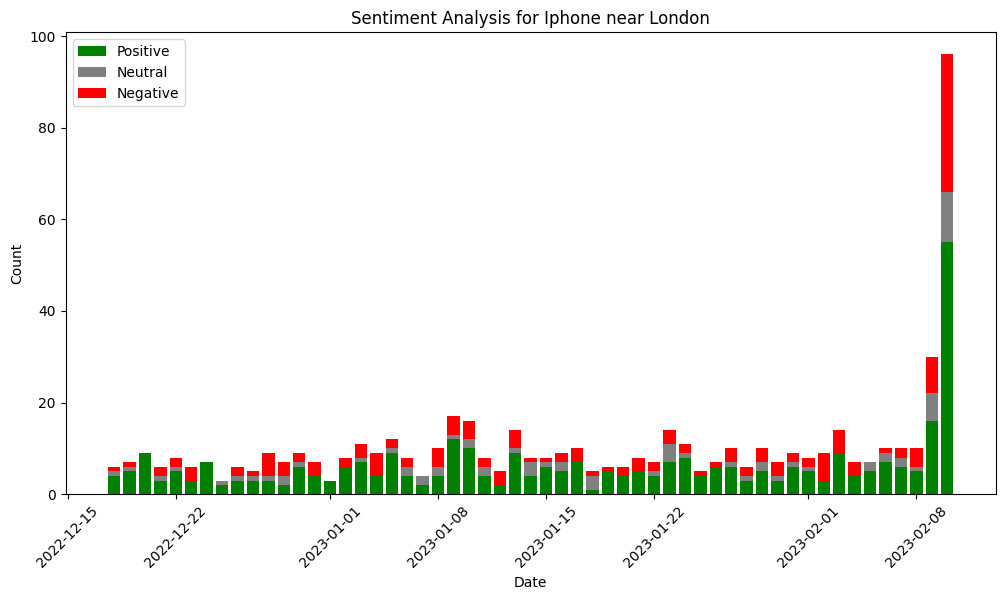

In [61]:
# Create a list of dates
# Convert the Datetime column to a datetime data type
Filteredtweets['Datetime'] = pd.to_datetime(Filteredtweets['Datetime'], format='%d/%m/%Y')

# Sort the DataFrame by the Datetime column
Filteredtweets = Filteredtweets.sort_values(by='Datetime')

dates = Filteredtweets['Datetime'].unique()

# Create a list of counts for each sentiment for each date
pos_counts = []
neg_counts = []
neu_counts = []

for date in dates:
    df = Filteredtweets[Filteredtweets['Datetime'] == date]
    pos_counts.append(len(df[df['Sentiment'] == 'positive']))
    neg_counts.append(len(df[df['Sentiment'] == 'negative']))
    neu_counts.append(len(df[df['Sentiment'] == 'neutral']))

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(dates, pos_counts, label='Positive', color='green')
ax.bar(dates, neu_counts, bottom=pos_counts, label='Neutral', color='gray')
ax.bar(dates, neg_counts, bottom=np.array(pos_counts)+np.array(neu_counts), label='Negative', color='red')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title(f'Sentiment Analysis for {topic} near {location}')
plt.xticks(rotation=45)

# Save the plot to a PNG file
plt.savefig('static/img/sentiment_stacked_bar_chart.png', dpi=300, bbox_inches='tight')


In [46]:
df

,index,Datetime,Text,Username,Retweet,Views,Search Criteria,Sentiment,TextClean,Tweetsentiment,TweetsentimentNoCleaning
11,488,31-12-2022,My #Iphone Just Reset Everyone's Birthday In M...,anwoodgate,0,84,Iphone,positive,my iphone just reset everyone is birthday in m...,neutral,negative
132,7078,31-12-2022,@Thecpe That?S Why The Mini Is The Best #Iphone,Cyber_Professor,0,98,Iphone,positive,thecpe thats why the mini is the best iphone,positive,positive
292,15423,31-12-2022,When You Rush To The Bathroom With Your #Iphon...,NaN,0,167,Iphone,positive,when you rush to the bathroom with your iphone...,negative,neutral
336,17738,31-12-2022,#Iphone Are Scam.,shawadli,0,17,Iphone,negative,iphone are scam,negative,negative
346,18297,31-12-2022,Which One Is The Best ? I Am Confused ? #Iphon...,adityablasters,0,109,Iphone,positive,which one is the best i am confused iphone poll,neutral,neutral
384,20214,31-12-2022,Seriously .@Apple. It?S 2023 And We Still Don?...,ifapplethen,0,59,Iphone,negative,seriously apple its 2023 and we still dont hav...,negative,negative
557,29782,31-12-2022,Android Or Iphone For A Hardcore Bitcoiner? #B...,kidnorth_btc,1,636,Iphone,negative,android or iphone for a hardcore bitcoiner bit...,neutral,neutral


In [35]:
neu_counts

[239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239,
 239]

In [ ]:
#Sentiment Classification Plot
# create the data for the plot
data = Filteredtweets['Tweetsentiment'].value_counts()
# create the bar plot
fig = go.Figure(data=[go.Bar(x=data.values, y=data.index, orientation='h', marker_color='darkblue')])
# customize the plot layout
fig.update_layout(title='Sentiment Classification', xaxis_title='Count', yaxis_title='Sentiment')
# save the plot as an image file
fig.write_image("static/SentimentClass.png")

In [ ]:
import base64
from io import BytesIO
import plotly.graph_objects as go

# create the data for the plot
data = Filteredtweets['Tweetsentiment'].value_counts()

# create the bar plot
fig = go.Figure(data=[go.Bar(x=data.values, y=data.index, orientation='h', marker_color='darkblue')])

# customize the plot layout
fig.update_layout(title='Sentiment Classification', xaxis_title='Count', yaxis_title='Sentiment')

# save the plot as an image file
img_bytes = fig.to_image(format='png')
encoded_image = base64.b64encode(img_bytes).decode('utf-8')

encoded_image

# pass the encoded image string to the template
#return render_template('index.html', plot=encoded_image)


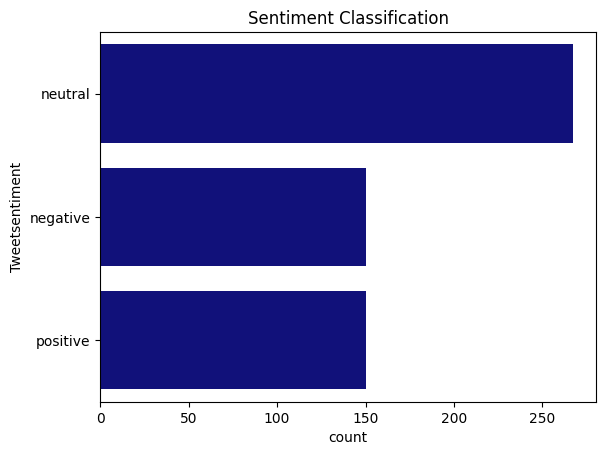

NameError: name 'SentimentClass' is not defined

In [22]:
sns.countplot(y='Tweetsentiment', data=Filteredtweets, color = 'darkblue')
plt.title('Sentiment Classification')
plt.show()

SentimentClass.savefig('static/SentimentClass.png')
plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(y='Tweetsentiment', data=Filteredtweets, color='darkblue', ax=ax)
ax.set_title('Sentiment Classification')
# Save the figure as a variable
SentimentClass = ax.get_figure()
# Or save it as an image
SentimentClass.savefig('static/SentimentClass.png')


In [ ]:
sns.countplot(y='TweetsentimentNoCleaning', data=Filteredtweets, color = 'darkblue')
plt.title('Tweetnlp with no Cleaning Sentiment Classification')
plt.show()

In [ ]:
sns.countplot(y='Sentiment', data=Filteredtweets, color = 'darkblue')
plt.title('Manual Sentiment Classification')
plt.show()

In [ ]:
Filteredtweets['CompareCnU'] = Filteredtweets['TweetsentimentNoCleaning'] == Filteredtweets['Tweetsentiment']

In [ ]:
Filteredtweets['CompareCnU'].value_counts()

In [ ]:
# Filter rows where Compare is False
false_compare = Filteredtweets.loc[Filteredtweets['CompareCnU'] == False, ['Text', 'TweetsentimentNoCleaning', 'Tweetsentiment', 'CompareCnU']]

# Print the resulting dataframe
pd.set_option('display.max_colwidth', None)
false_compare.head(20)

In [ ]:
# Print the resulting dataframe
pd.set_option('display.max_colwidth', None)
false_compare.tail(20)

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 

 

In [ ]:
# Wordcloud with positive tweets
positive_tweets = Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'positive']
stop_words = ["iphone"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=60, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Wordcloud with positive tweets
positive_tweets = Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'negative']
stop_words = ["iphone"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=60, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
OverallSentiment = Filteredtweets['Tweetsentiment'].mode()[0]

In [ ]:
print('OverallSentiment: '+ OverallSentiment)

In [69]:
# Group the dataframe by date and sentiment class and count the number of tweets in each group
tweet_counts

Tweetsentiment,negative,neutral,positive
Datetime,,,
2022-12-18,2,4,0
2022-12-19,0,5,2
2022-12-20,0,8,1
2022-12-21,4,2,0
2022-12-22,3,2,3
2022-12-23,2,3,1
2022-12-24,2,3,2
2022-12-25,0,1,2
2022-12-26,2,4,0


In [67]:
# Convert the Datetime column to a datetime data type
tweet_counts['Date'] = pd.to_datetime(tweet_counts['Datetime'], format='%d-%m-%Y')



KeyError: 'Datetime'

In [68]:
# Sort the DataFrame by the Datetime column
tweet_counts = tweet_counts.sort_values(by='Datetime')

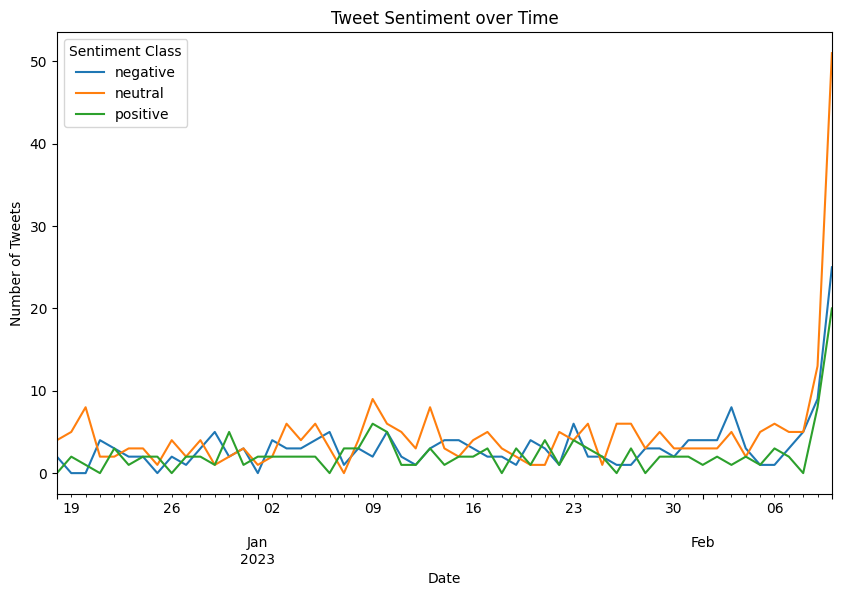

In [64]:
# Group the dataframe by date and sentiment class and count the number of tweets in each group
tweet_counts = Filteredtweets.groupby(['Datetime', 'Tweetsentiment']).size().unstack(fill_value=0)

# Plot the line graph
fig, ax = plt.subplots(figsize=(10, 6))
tweet_counts.plot(ax=ax)

# Add titles and labels
ax.set_title('Tweet Sentiment over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.legend(title='Sentiment Class', loc='upper left')
Sentimentovertime = ax.get_figure()
Sentimentovertime.savefig('static/Sentimentovertime.png')


In [ ]:
    #Sentiment Classification Plot
    fig, ax = plt.subplots(figsize=(8,6))
    sns.countplot(y='Tweetsentiment', data=tweets_df, color='darkblue', ax=ax)
    ax.set_title('Sentiment Classification')
    # Save the figure as a variable
    SentimentClass = ax.get_figure()
    # save it as an image
    SentimentClass.savefig('static/SentimentClass.png')

In [ ]:
Filteredtweets2 = Filteredtweets.copy()

In [ ]:
# convert the Datetime column to a pandas datetime object
Filteredtweets2['Datetime'] = pd.to_datetime(Filteredtweets2['Datetime'], dayfirst=True)

In [ ]:
sentiment_coding = {'positive':1, 'negative':-1, 'neutral': 0} # Define a mapping of old values to new values
Filteredtweets2['Tweetsentiment'] = Filteredtweets2['Tweetsentiment'].replace(sentiment_coding)

In [ ]:
Filteredtweets2.info()

In [ ]:
Filteredtweets2.head(1)

In [ ]:
# convert the Datetime column to a pandas datetime object
Filteredtweets2['Datetime'] = pd.to_datetime(Filteredtweets2['Datetime'])

# group by day and compute the mode of the Tweetsentiment column
daily_mode = Filteredtweets2.groupby(pd.Grouper(key='Datetime', freq='D'))['Tweetsentiment'].apply(lambda x: x.mode())

# plot the daily mode of the Tweetsentiment column
fig, ax = plt.subplots(figsize=(10, 6))
daily_mode.plot(ax=ax, kind='line')
ax.set_xlabel('Date')
ax.set_ylabel('Mode of Tweetsentiment')
ax.set_title('Daily Mode of Tweetsentiment')
plt.show()

In [ ]:
# convert the Datetime column to a pandas datetime object
Filteredtweets2['Datetime'] = pd.to_datetime(Filteredtweets2['Datetime'])

# group by week and compute the mode of the Tweetsentiment column
weekly_mode = Filteredtweets2.groupby(pd.Grouper(key='Datetime', freq='W'))['Tweetsentiment'].apply(lambda x: x.mean())

# plot the weekly mode of the Tweetsentiment column
fig, ax = plt.subplots(figsize=(10, 6))
weekly_mode.plot(ax=ax, kind='line')
ax.set_xlabel('Date')
ax.set_ylabel('Average of Tweetsentiment')
ax.set_title('Weekly Average of Tweetsentiment')
plt.show()


In [ ]:
# convert the Datetime column to a pandas datetime object
Filteredtweets2['Datetime'] = pd.to_datetime(Filteredtweets2['Datetime'])

# group by week and compute the mode of the Tweetsentiment column
weekly_mode = Filteredtweets2.groupby(pd.Grouper(key='Datetime', freq='W'))['Tweetsentiment'].apply(lambda x: x.mean())

# plot the weekly mode of the Tweetsentiment column
fig, ax = plt.subplots(figsize=(10, 6))
weekly_mode.plot(ax=ax, kind='line')
ax.set_xlabel('Date')
ax.set_ylabel('Average of Tweetsentiment')
ax.set_title('Weekly Average of Tweetsentiment')
ax.axhline(y=0, color='gray', linestyle='--')
plot_WeeklyAverage = ax.get_figure()
plt.show()


In [ ]:
plot_WeeklyAverage

In [ ]:
# Wordcloud with positive tweets
negative_tweets = Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'negative']
stop_words = ["iphone"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=60, max_words=50, background_color="white", stopwords=stop_words).generate(str(negative_tweets))

# Save the figure as a variable
fig = plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")

# Display the figure using plt.show()
plt.show()

In [ ]:
topic = 'Iphone'

In [ ]:
# Wordcloud with Negative tweets
NegativeWC = plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(WordCloud(width=700, height=400,max_font_size=80, max_words=50, background_color="white", stopwords=([topic.lower()] + list(STOPWORDS))).generate(str(Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'negative'])), interpolation="bilinear")
plt.axis("off")

# Display the figure using plt.show()
plt.show()
NegativeWC.savefig('static/Nwordcloud.png')
plt.close()

PositiveWC = plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(WordCloud(width=700, height=400,max_font_size=80, max_words=50, background_color="white", stopwords=([topic.lower()] + list(STOPWORDS))).generate(str(Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'positive'])), interpolation="bilinear")
plt.axis("off")

# Display the figure using plt.show()
plt.show()
PositiveWC.savefig('static/Pwordcloud.png')
plt.close()

In [ ]:
NegativeWC.savefig('static/Nwordcloud.png')
PositiveWC.savefig('static/Pwordcloud.png')

In [ ]:
PositiveWC

In [ ]:
NegativeWC

In [ ]:
# Wordcloud with positive tweets
positive_tweets = Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'negative']
stop_words = ["iphone"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=60, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
PositiveWC = plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(WordCloud(width=700, height=400,max_font_size=80, max_words=50, background_color="white", stopwords=([topic.lower()] + list(STOPWORDS))).generate(str(Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'positive'])), interpolation="bilinear")
plt.axis("off")

# Display the figure using plt.show()
plt.show()
plt.close()

In [ ]:
(Filteredtweets['Text'][Filteredtweets['Tweetsentiment'] == 'negative']).head()

In [ ]:
Filteredtweets =Filteredtweets.sort_values(by=['Views'], ascending=False)

In [ ]:
Filteredtweets[Filteredtweets['Tweetsentiment'] == 'negative'].sort_values(by=['Views'], ascending=False).head(10)


In [ ]:
top_negative_tweets = Filteredtweets.loc[Filteredtweets['Tweetsentiment'] == 'negative'].sort_values(by=['Views'], ascending=False).loc[:, ['Datetime', 'Text', 'Views']].head(10)
top_negative_tweets

In [ ]:
top_positive_tweets = Filteredtweets.loc[Filteredtweets['Tweetsentiment'] == 'positive'].sort_values(by=['Views'], ascending=False).loc[:, ['Datetime', 'Text', 'Views']].head(10)
top_positive_tweets

In [ ]:
top_negative_tweets

In [33]:
location = 'london'

In [34]:
location = location.title()

In [35]:
location

'London'

In [2]:
snscrape twitter-user textfiles

SyntaxError: invalid syntax (2547846997.py, line 1)

In [3]:
txt = snscrape twitter-user textfiles

SyntaxError: invalid syntax (3556694035.py, line 1)

In [4]:
txt = snscrape --max-results 100 twitter-hashtag archiveteam

SyntaxError: invalid syntax (706509363.py, line 1)